In [1]:
# Import the necessary packages
import torch
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import r2_score
import random
import matplotlib as mpl
import os
import gc
from torch.utils.tensorboard import SummaryWriter
from datetime import date
mpl.rcParams['figure.dpi'] = 300

In [2]:
# Set up the Cuda device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# LSTM Model Class from the Training.py file
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_layers, seq_len,num_classes=1):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.seq_len = seq_len

        self.bnn1 = nn.Linear(input_size, 32)
        self.bnn2 = nn.Linear(32,64)
        self.bnn3 = nn.Linear(64,64)
        self.bnn4 = nn.Linear(64,64)

        self.lstm1 = nn.LSTM(64, hidden_size1, num_layers, batch_first=True, bidirectional=True, dropout=0.5)
        self.bn_lstm1 = nn.BatchNorm1d(2*hidden_size1,device=device)  
        self.nn1 = nn.Linear(2*hidden_size1, 2*hidden_size1)
        self.nn2 = nn.Linear(2*hidden_size1, 512)
        self.nn3 = nn.Linear(512, 512)
        self.nn4 = nn.Linear(512, 256)
        self.nn5 = nn.Linear(256, 256)
        self.nn6 = nn.Linear(256, 128)
        self.nn7 = nn.Linear(128, 32)
        self.nn8 = nn.Linear(32, 1)

    
        self.relu = nn.ReLU()


        
    def forward(self, x, array_lengths):
        inital_seq_len = x.size(1)
        x = Variable(x.float()).to(device)

        x = torch.reshape(x, (x.size(0)*x.size(1), x.size(2)))
        out = self.bnn1(x)
        out = self.relu(out)
        out = self.bnn2(out)
        out = self.relu(out)
        out = self.bnn3(out)
        out = self.relu(out)
        out = self.bnn4(out)
        out = self.relu(out)

        ## reshaping again
        out = torch.reshape(out, (-1, inital_seq_len, out.size(1)))
        
        pack = nn.utils.rnn.pack_padded_sequence(out, array_lengths, batch_first=True, enforce_sorted=False)
        h0 = Variable(torch.zeros(2*self.num_layers, x.size(0), self.hidden_size1).to(device))
        c0 = Variable(torch.zeros(2*self.num_layers, x.size(0), self.hidden_size1).to(device))
        h1 = Variable(torch.zeros(2*self.num_layers, self.hidden_size1, self.hidden_size2).to(device))
        c1 = Variable(torch.zeros(2*self.num_layers, self.hidden_size1, self.hidden_size2).to(device))
        
        # Forward propagate RNN
        out, _ = self.lstm1(pack, (h0,c0))
        del(h0)
        del(c0)
        gc.collect()
        unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        this_batch_len = unpacked.size(1)
        out = unpacked
        out = torch.reshape(out, (out.size(0)*out.size(1), out.size(2)))

        ##nn
        out = self.nn1(out)
        out = self.relu(out)
        out = self.nn2(out)
        out = self.relu(out)
        out = self.nn3(out)
        out = self.relu(out)
        out = self.nn4(out)
        out = self.relu(out)
        out = self.nn5(out)
        out = self.relu(out)
        out = self.nn6(out)
        out = self.relu(out)
        out = self.nn7(out)
        out = self.relu(out)
        out = self.nn8(out)
        
        ## reshaping
        out = torch.reshape(out, (-1, this_batch_len, 1))
        

        return out

In [4]:
# Select the epoch weights to use and call them
epoch_check =400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device is',device)

model_test = torch.load('/home/tjdean2/research_data/CHBE594/class_project/models/LSTM/weights/epoch_'+ str(epoch_check) + '.pth', map_location='cuda')
model_test.eval().to(device)
print(model_test)
for p in model_test.parameters():
    print(p.size())

# Print the parameters to make sure everything is making sense
params = sum([np.prod(p.size()) for p in model_test.parameters()])
print(params)

Device is cuda
RNN(
  (bnn1): Linear(in_features=1308, out_features=32, bias=True)
  (bnn2): Linear(in_features=32, out_features=64, bias=True)
  (bnn3): Linear(in_features=64, out_features=64, bias=True)
  (bnn4): Linear(in_features=64, out_features=64, bias=True)
  (lstm1): LSTM(64, 512, batch_first=True, dropout=0.5, bidirectional=True)
  (bn_lstm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nn1): Linear(in_features=1024, out_features=1024, bias=True)
  (nn2): Linear(in_features=1024, out_features=512, bias=True)
  (nn3): Linear(in_features=512, out_features=512, bias=True)
  (nn4): Linear(in_features=512, out_features=256, bias=True)
  (nn5): Linear(in_features=256, out_features=256, bias=True)
  (nn6): Linear(in_features=256, out_features=128, bias=True)
  (nn7): Linear(in_features=128, out_features=32, bias=True)
  (nn8): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
  (drop): Dropout(p=0.5, inplace=

In [5]:
# Load in the testing set index
x_test = np.load('x_test.npy', allow_pickle=True)

class BetaDataset(Dataset) :
    def __init__(self,x,y, n_samples) :
        self.x = x
        self.y = y 
        self.n_samples = n_samples
        
        
    def __getitem__(self,index) :
        return self.x[index], self.y[index]

    def __len__(self) :    
        return self.n_samples      

test_dataset = BetaDataset(x_test,x_test,np.shape(x_test)[0])


test_loader = DataLoader(dataset=test_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

print('Number of test data set', np.shape(x_test)[0])

Number of test data set 120


In [6]:
# Now, we actually run through the model to make the predictions

from math import nan

all_x = np.load('/home/tjdean2/research_data/CHBE594/class_project/dataset/x_full_3000_fixed' + '.npy', allow_pickle=True)
all_y = np.load('/home/tjdean2/research_data/CHBE594/class_project/dataset/y_3000' + '.npy', allow_pickle=True)

p_beta = torch.zeros((1)).to(device)
a_beta = torch.zeros((1)).to(device)
collection_test = 0
avg_pearson_count = 0
avg_pearson = 0
avg_r2 = 0
count_all = 0
pearson_coeff = torch.zeros((np.shape(x_test)[0], ))
pearson_count = 0
with torch.no_grad():
  for i, (parameters, no_req) in enumerate(test_loader):
    # parameters = parameters.to(device)
    input_x = torch.from_numpy(all_x[parameters,:,:]).to(device)
    output_y = torch.from_numpy(all_y[parameters,:,:]).to(device)
    input_x = torch.reshape(input_x, (input_x.size(0), input_x.size(2), input_x.size(3)))
    output_y = torch.reshape(output_y, (output_y.size(0), output_y.size(2), output_y.size(3)))
    
    # forward pass  
    array_lengths = input_x[:,0,1308]
    array_lengths = array_lengths.int()
    array_lengths = array_lengths.tolist()
    outputs = model_test(input_x[:,:,0:1308], array_lengths)
    outputs = torch.reshape(outputs, (-1,int(max(array_lengths))) )
    output_y = torch.reshape(output_y[:,0:int(max(array_lengths)), 0], (-1,int(max(array_lengths))))

    outputs = outputs.T
    output_y = output_y.T

    # Now that we have our predictions, only compare the real residues of each protein and calculate the PCC for each protein
    for j in range(input_x.size()[0]):    
      prot_len = int(input_x[j,0,1308].item())
      if prot_len != 0:
        a_beta = torch.cat((torch.flatten(output_y[0:prot_len,j].float()), a_beta.float()),0)
        p_beta = torch.cat((torch.flatten(outputs[0:prot_len,j].float()), p_beta.float()),0)
        
        if math.isnan(np.corrcoef(outputs[0:prot_len,j].cpu(), output_y[0:prot_len,j].cpu())[0,1]):
          print('nan')
        else:
          avg_pearson =  (avg_pearson*avg_pearson_count + np.corrcoef(outputs[0:prot_len,j].cpu(), output_y[0:prot_len,j].cpu())[0,1])/(avg_pearson_count+1)
          avg_r2 = (avg_r2*avg_pearson_count + r2_score(outputs[0:prot_len,j].cpu(), output_y[0:prot_len,j].cpu()))/(avg_pearson_count+1)
          avg_pearson_count += 1
          count_all = count_all + prot_len
          
          pearson_coeff[pearson_count,] = np.corrcoef(outputs[0:prot_len,j].cpu(), output_y[0:prot_len,j].cpu())[0,1]
          pearson_count += 1
          if pearson_coeff[pearson_count-1,] < 0.0:
            print(prot_len)

    
    del(input_x)
    del(output_y)
    gc.collect()

a_beta = a_beta[1:,]
p_beta = p_beta[1:,]

# Print the final outputs to look at
print('Total data collected', a_beta.size(0))
print('Total data predicted', p_beta.size(0))
print('Avgerage Pearson coefficient is', avg_pearson)
print('min', torch.min(pearson_coeff[0:pearson_count]))
print('max', torch.max(pearson_coeff[0:pearson_count]))

tensor([[1779],
        [ 341],
        [1276],
        [1012],
        [ 470],
        [1755],
        [2773],
        [1085],
        [2055],
        [2585],
        [ 241],
        [2040],
        [2261],
        [ 245],
        [2621],
        [1983],
        [1399],
        [ 998],
        [1182],
        [ 145],
        [ 108],
        [1331],
        [ 282],
        [1198],
        [2543],
        [1216],
        [ 410],
        [  29],
        [ 543],
        [ 854],
        [1625],
        [ 363],
        [2004],
        [1400],
        [2018],
        [1872],
        [2596],
        [1658],
        [1118],
        [ 845],
        [ 835],
        [2082],
        [1092],
        [2876],
        [1295],
        [1351],
        [ 148],
        [2050],
        [1891],
        [1307],
        [ 709],
        [2509],
        [1797],
        [2191],
        [1033],
        [1425],
        [ 528],
        [2019],
        [1082],
        [ 764],
        [1676],
        [ 922],
        

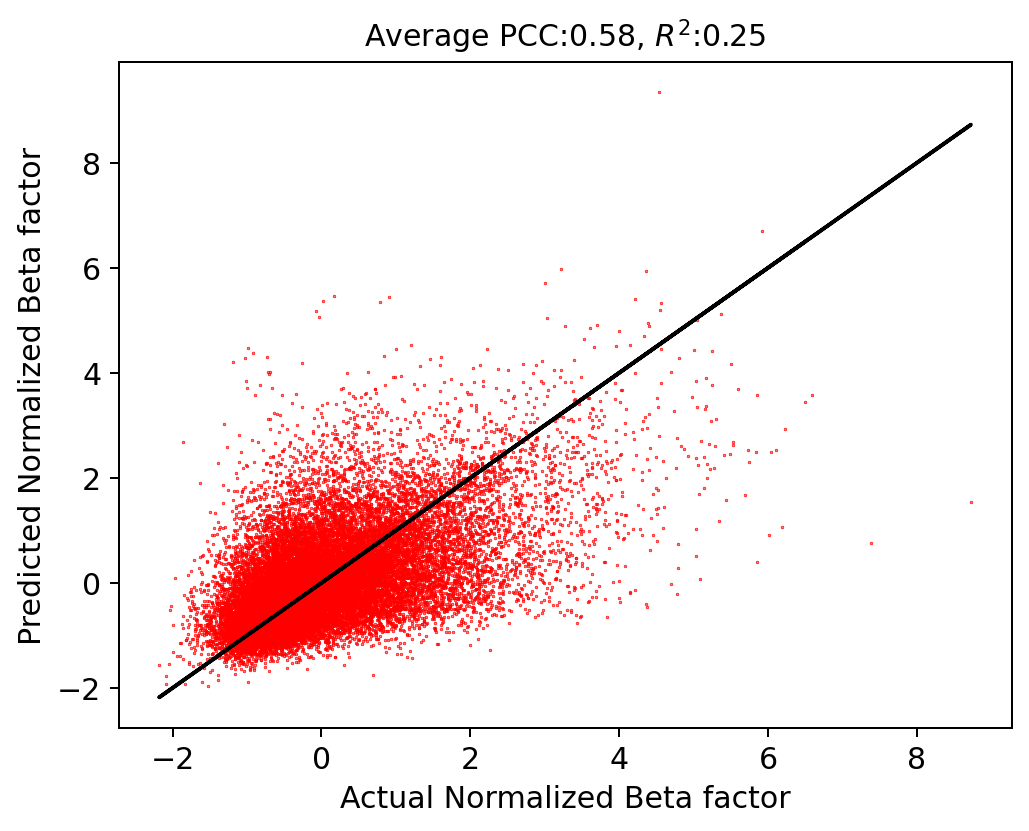

In [11]:
# Now, we plot the average pcc, r2, and show predicted vs actual for each
with torch.no_grad():
    plt.figure(1)
    # plt.rcParams.update({'font.size': 16})
    plt.scatter(a_beta.cpu(), p_beta.cpu(), s=0.1, color='red')
    plt.plot(a_beta.cpu(), a_beta.cpu(),'k')
    plt.title(f'Average PCC:{round(avg_pearson,2)}, $R^2$:{round(r2_score(a_beta.cpu(), p_beta.cpu()),2)}')
    plt.xlabel(r'Actual Normalized Beta factor', fontsize=12)
    plt.ylabel(r'Predicted Normalized Beta factor', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    # plt.xlim([0,80])
    # plt.ylim([0,80])
    plt.savefig('Big_model_averagepcc.png',dpi=300)
    plt.show()

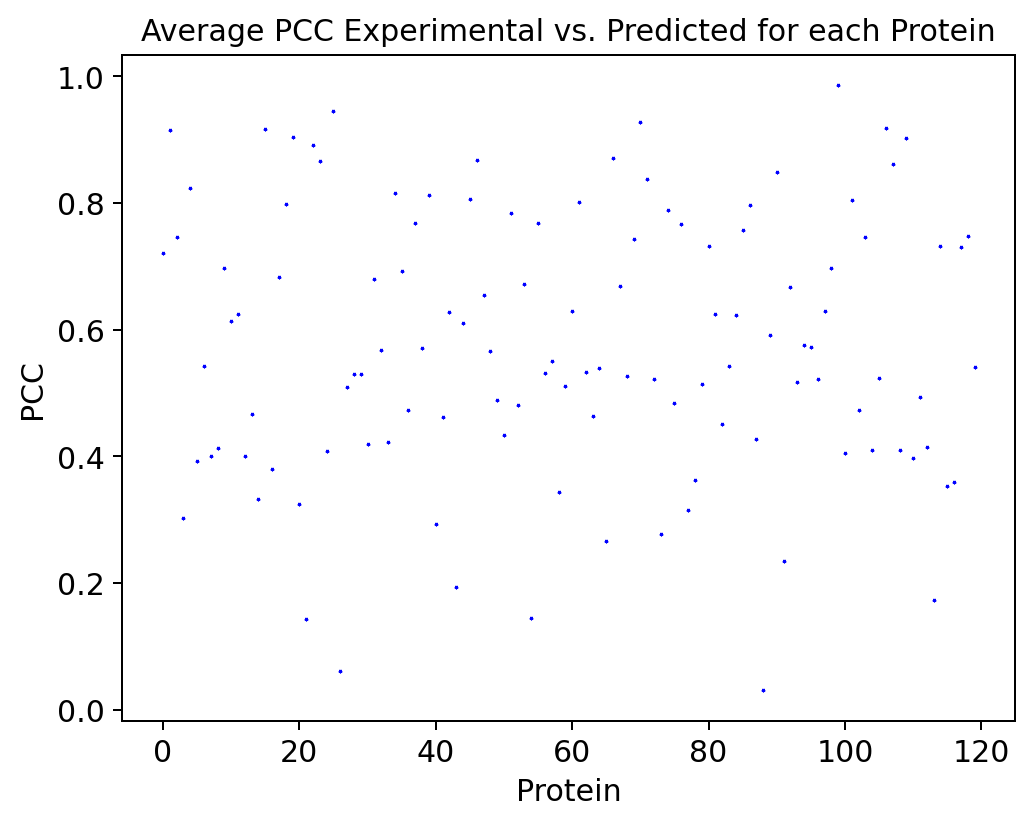

In [17]:
# Now we show how it varies for each protein
plt.figure(1)
plt.plot(pearson_coeff, '*', markersize=1, color='blue')
plt.title('Average PCC Experimental vs. Predicted for each Protein', fontsize=12)
plt.ylabel(r'PCC', fontsize=12)
plt.xlabel(r'Protein', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('PCC_exp_vs_pred_test.png',dpi=300)
plt.show()

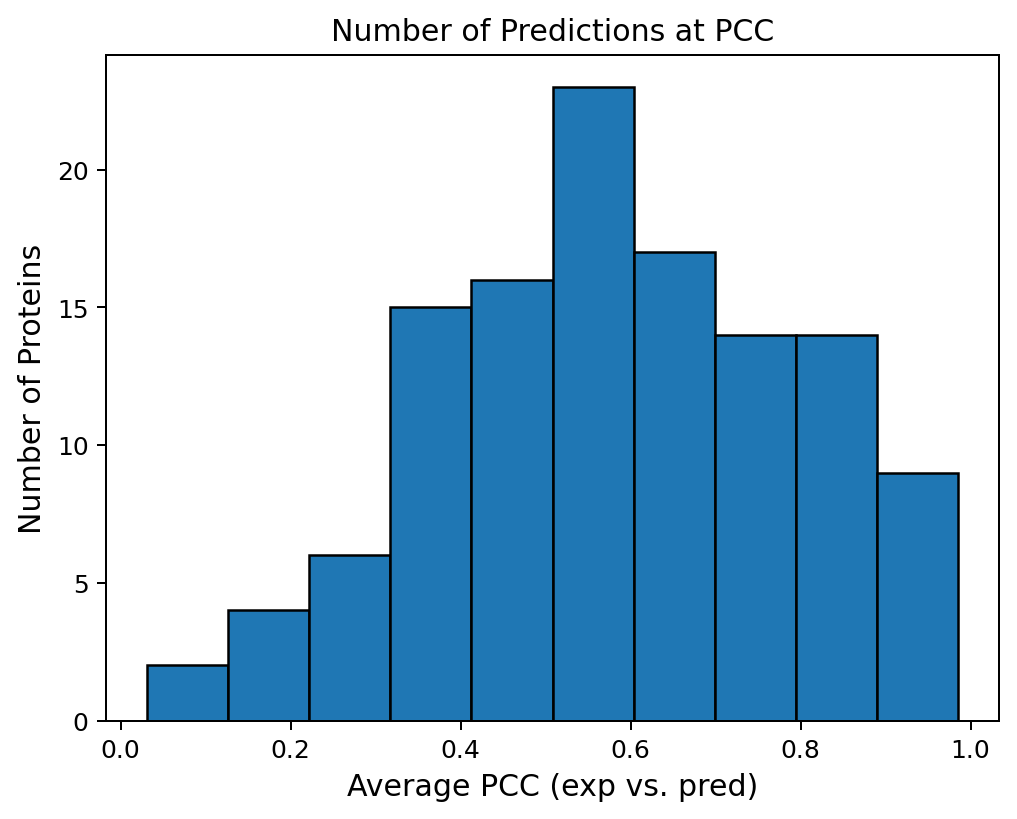

In [22]:
# Now we show how the proteins in the test dataset are split into bins by average PCC
n, bins, patches = plt.hist(pearson_coeff, bins=10,edgecolor='black')
plt.title(r'Number of Predictions at PCC', fontsize=12)
plt.xlabel(r'Average PCC (exp vs. pred)', fontsize=12)
plt.ylabel(r'Number of Proteins', fontsize=12)

plt.savefig('Pred_pcc_range.png',dpi=300)
plt.show()